import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

#sys.path.append('/home/skong2/project/dpff4ldl')
#from utils.metrics import *
#from utils.metrics import *
#from utils.flow_functions import *
#from models.pem import *
#from models.PEM_compact import *
#from fetchData.datasetCOMBINED import *
#from trainingProtocol.trainval_COM2s_intFlow_LazyPrior_bidirection import *
#from trainingProtocol.trainval_COM2s_intFlow_sLazyPrior_bidirectionAllLayers import *
#from losses import *
#from losses_suppl import *

from utils.flow_functions import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

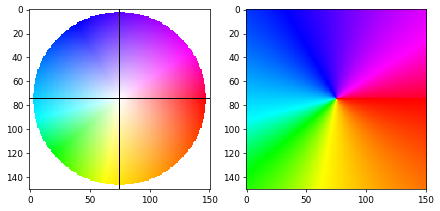

In [2]:
objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())

figWinNumHeight, figWinNumWidth = 1, 2
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=64, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(objDemoShowFlow.FlowColorChart)

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(objDemoShowFlow.FlowColorChartNoAxes)

#misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

In [3]:
path_to_imdb = '/home/skong2/restore/dataset/BCI_pollenDetClsSystem_dataset/imdb_files/imdb_segDet.mat'
mat = scipy.io.loadmat(path_to_imdb)
mat = mat['imdb'][0][0]
func = transforms.ToTensor()

randNumList = mat[0][0] # [1×16425 double]
slideNumList = mat[1][0] # [1×16425 double]
absXList = mat[2][0] #: [1×16425 double]
absYList = mat[3][0] #: [1×16425 double]
annotPollenNumList = mat[4][0] #: [1×16425 double]
relativeXList = mat[5][0] #: [1×16425 double]
relativeYList = mat[6][0] #: [1×16425 double]
zPlaneList = mat[7][0] #: [1×16425 double]
radiusList = mat[8][0] #: [1×16425 double]
confList = mat[9][0] #: [1×16425 double]
labelNameList = mat[10][0] #: {1×16425 cell}
className = mat[11][0] #: {1×131 cell}
classMapping_Name2Label = mat[12][0] #: [131×1 containers.Map]
labelList = mat[13][0] #: [1×16425 double]
imgpathList = mat[14][0] #: {1×16425 cell}
path_to_mask = mat[15][0] #: '/home/skong2/pollenProject_dataset_mask'
path_to_image = mat[16][0] #: '/home/skong2/pollenProject_dataset'
imgList = mat[17][0] #: {1×16425 cell}
maskList = mat[18][0] #: {1×16425 cell}

In [7]:
idx = 519 # 1 19

relX = int(relativeXList[idx])
relY = int(relativeYList[idx])
radius = radiusList[idx]
filename_image = imgList[idx][0].replace('pollenProject_dataset','restore/dataset/pollenProject_dataset_part1')
filename_label = maskList[idx][0].replace('pollenProject_dataset_mask','restore/dataset/pollenProject_dataset_mask')
print(filename_image)
print(filename_label)

image = PIL.Image.open(filename_image)
label = PIL.Image.open(filename_label)
image = np.array(image)
label = np.array(label)
#image = func(image)
#label = func(label)

mask_distanceTransform = ndimage.distance_transform_edt(label)
print(mask_distanceTransform.max())
coord_peaks = feature.peak_local_max(mask_distanceTransform, min_distance=10)
mask_peaks = label*0.
mask_radius = label*0.
mask_voteX = label*0.
mask_voteY = label*0.
mask_overlap = label*0.
r_list = []
annot = dict()
annot['size'] = label.shape
for i in range(coord_peaks.shape[0]):
    y, x = coord_peaks[i]
    r = mask_distanceTransform[y, x]
    r_list += [r]
    #mask_peaks[y-10:y+10, x-10:x+10] = 1
    #mask_radius[y-10:y+10, x-10:x+10] = r
    mask_peaks[y, x] = 1
    mask_radius[y, x] = r
    
    #tmpmask_vote = np.zeros((image.shape[0], image.shape[1]))
    mask_x, mask_y = np.asarray(range(image.shape[1])).astype(np.float), np.asarray(range(image.shape[0])).astype(np.float)
    mask_x, mask_y = np.meshgrid(mask_x, mask_y)
    mask_x = float(x) - mask_x
    mask_y = float(y) - mask_y
    
    tmpmask_vote = mask_x*mask_x + mask_y*mask_y <= r*r
    mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
    mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
    mask_overlap += tmpmask_vote.astype(np.float)
mask_overlap = mask_overlap>1
mask_overlap = mask_overlap.astype(np.uint8)    

annot['coord_peaks'] = coord_peaks
annot['mask_radius'] = r_list

with open('test.plk', 'wb') as handle:
    pickle.dump(annot, handle) # , protocol=pickle.HIGHEST_PROTOCOL

/home/skong2/restore/dataset/pollenProject_dataset_part1/hyr/9.1994-1995-10-20.83.-5.53000.55000.png
/home/skong2/restore/dataset/pollenProject_dataset_mask/hyr/9.1994-1995-10-20.83.-5.53000.55000.bmp
66.57326790837296


In [8]:
with open('test.plk', 'rb') as handle:
    annot = pickle.load(handle)

label = np.zeros((annot['size'][0], annot['size'][1]))

mask_distanceTransform = label*0.
mask_peaks = label*0.
mask_radius = label*0.
mask_voteX = label*0.
mask_voteY = label*0.
mask_overlap = label*0.
for i in range(annot['coord_peaks'].shape[0]):
    y, x = annot['coord_peaks'][i]
    r = annot['mask_radius'][i]
    
    mask_peaks[y-10:y+10, x-10:x+10] = 1
    mask_radius[y-10:y+10, x-10:x+10] = r
    #mask_peaks[y, x] = 1
    #mask_radius[y, x] = r
    
    mask_x, mask_y = np.asarray(range(label.shape[1])).astype(np.float), np.asarray(range(label.shape[0])).astype(np.float)
    mask_x, mask_y = np.meshgrid(mask_x, mask_y)
    mask_x = float(x) - mask_x
    mask_y = float(y) - mask_y
    
    tmpDistTransform = np.sqrt(mask_x*mask_x + mask_y*mask_y)
    tmpmask_vote = tmpDistTransform <= r
    label[tmpmask_vote] = 1
    mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
    mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
    mask_distanceTransform[tmpmask_vote] = r-tmpDistTransform[tmpmask_vote]
    mask_overlap += tmpmask_vote.astype(np.float)
mask_overlap = mask_overlap>1
mask_overlap = mask_overlap.astype(np.uint8)    


# annotMat['peak'] = mask_peaks.astype(np.bool)
# annotMat['segm'] = label.astype(np.bool)
# annotMat['distTransform'] = mask_distanceTransform
# annotMat['radius'] = mask_radius
# annotMat['segm'] = label.astype(np.bool)
# annotMat['overlap'] = mask_overlap.astype(np.bool)
# annotMat['mask_voteX'] = mask_voteX
# annotMat['mask_voteY'] = mask_voteY

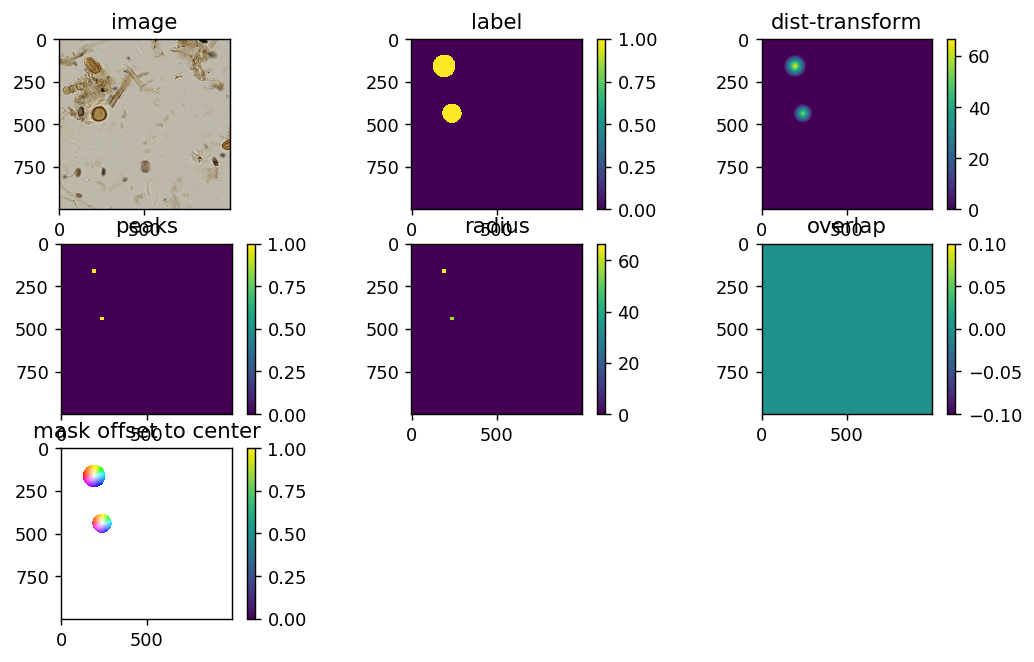

In [9]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 3
plt.figure(figsize=(10, 6), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(image)
#plt.axis('off')
plt.title('image')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(label)
#plt.axis('off')
plt.title('label')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_distanceTransform)
#plt.axis('off')
plt.title('dist-transform')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_peaks)
#plt.axis('off')
plt.title('peaks')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_radius)
#plt.axis('off')
plt.title('radius')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(mask_overlap)
#plt.axis('off')
plt.title('overlap')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
flowVisShow = objDemoShowFlow.computeColor(
    mask_voteX/np.abs(mask_voteX).max(), 
    mask_voteY/np.abs(mask_voteY).max())/255.    
plt.imshow(flowVisShow)
#plt.axis('off')
plt.title('mask offset to center')
plt.colorbar()

In [10]:
path_to_image = '/home/skong2/restore/dataset/pollenProject_dataset_part1'
path_to_label = '/home/skong2/restore/dataset/pollenProject_dataset_mask'
path_to_save = '/home/skong2/restore/dataset/pollenProject_dataset_annotationCombo'

if not os.path.exists(path_to_save): 
    os.makedirs(path_to_save)

labelIdx = []
samplePathList = []
labelNameList = []
labelIDxList = []
labelIdxCount = 0
dict_classCount = dict()
for subfolder in os.listdir(path_to_image):            
    set_path = []
    tmpSampleList = os.listdir(path.join(path_to_image, subfolder))# self.sorted_dir
    if len(tmpSampleList)>=1:
        dict_classCount[subfolder] = len(tmpSampleList)
        for sampleFile in tmpSampleList: # self.sorted_dir
            if sampleFile.endswith((".png","_files")): 
                samplePathList += [path.join(subfolder, sampleFile[:-4])]
                labelNameList += [subfolder]
                labelIDxList += [labelIdxCount] 
        labelIdxCount += 1

In [11]:
len(samplePathList), samplePathList[0], labelNameList[0]

(6215, 'mor/30.1996-1997-10-01.100.-5.11000.37000', 'mor')

In [21]:
for idx in range(len(samplePathList)):
    curClassName = labelNameList[idx]
    curImageName = path.join(path_to_image, samplePathList[idx]+'.png')
    curLabelName = path.join(path_to_label, samplePathList[idx]+'.bmp')
    
    if idx%50==0:
        print(idx, curImageName)
    
    label = PIL.Image.open(curLabelName)
    #image = np.array(image)
    label = np.array(label)
    label = label[:1000,:1000]
    
    tmpdir = path.join(path_to_save, curClassName)
    if not os.path.exists(tmpdir): 
        os.makedirs(tmpdir)
    
    mask_distanceTransform = ndimage.distance_transform_edt(label)
    coord_peaks = feature.peak_local_max(mask_distanceTransform, min_distance=10)
    mask_peaks = label*0.
    mask_radius = label*0.
    mask_voteX = label*0.
    mask_voteY = label*0.
    mask_overlap = label*0.
    r_list = []
    annot = dict()
    annot['size'] = label.shape
    for i in range(coord_peaks.shape[0]):
        y, x = coord_peaks[i]
        r = mask_distanceTransform[y, x]
        r_list += [r]
        #mask_peaks[y-10:y+10, x-10:x+10] = 1
        #mask_radius[y-10:y+10, x-10:x+10] = r
        mask_peaks[y, x] = 1
        mask_radius[y, x] = r

        #tmpmask_vote = np.zeros((image.shape[0], image.shape[1]))
        mask_x, mask_y = np.asarray(range(label.shape[1])).astype(np.float), np.asarray(range(label.shape[0])).astype(np.float)
        mask_x, mask_y = np.meshgrid(mask_x, mask_y)
        mask_x = float(x) - mask_x
        mask_y = float(y) - mask_y

        tmpmask_vote = mask_x*mask_x + mask_y*mask_y <= r*r
        mask_voteX[tmpmask_vote] = mask_x[tmpmask_vote]
        mask_voteY[tmpmask_vote] = mask_y[tmpmask_vote]
        mask_overlap += tmpmask_vote.astype(np.float)
    mask_overlap = mask_overlap>1
    mask_overlap = mask_overlap.astype(np.uint8)    

    annot['coord_peaks'] = coord_peaks
    annot['mask_radius'] = r_list
    
    pkl_filename = path.join(path_to_save, samplePathList[idx]+'.pkl')
    with open(pkl_filename, 'wb') as handle:
        pickle.dump(annot, handle) # , protocol=pickle.HIGHEST_PROTOCOL

650 /home/skong2/restore/dataset/pollenProject_dataset_part1/mor/25.1995-1996-15-30.10.1.42000.40000.png
700 /home/skong2/restore/dataset/pollenProject_dataset_part1/mor/46.1994-1995-10-30.65.-7.11000.31000.png
750 /home/skong2/restore/dataset/pollenProject_dataset_part1/mor/86.1995-1996-15-15.79.-7.52000.48000.png
800 /home/skong2/restore/dataset/pollenProject_dataset_part1/mor/13.1994-1995-15-30.11.5.16000.46000.png
850 /home/skong2/restore/dataset/pollenProject_dataset_part1/mor/40.1995-1996-15-05.78.1.46000.56000.png
900 /home/skong2/restore/dataset/pollenProject_dataset_part1/mor/36.1996-1997-10-30.66.1.29000.32000.png
950 /home/skong2/restore/dataset/pollenProject_dataset_part1/mor/120.1994-1995-15-25.440.0.79000.61000.png
1000 /home/skong2/restore/dataset/pollenProject_dataset_part1/mor/60.1995-1996-15-30.60.0.19000.52000.png
1050 /home/skong2/restore/dataset/pollenProject_dataset_part1/mor/22.1995-1996-15-20.85.0.48000.19000.png
1100 /home/skong2/restore/dataset/pollenProject_d

4500 /home/skong2/restore/dataset/pollenProject_dataset_part1/alc/123.1995-1996-10-40.50.-14.26000.31000.png
4550 /home/skong2/restore/dataset/pollenProject_dataset_part1/sim/69.1995-1996-10-25.36.-3.51000.71000.png
4600 /home/skong2/restore/dataset/pollenProject_dataset_part1/sim/16.1996-1997-10-25.83.-1.44000.46000.png
4650 /home/skong2/restore/dataset/pollenProject_dataset_part1/ape/6.1996-1997-10-25.25.-1.23000.44000.png
4700 /home/skong2/restore/dataset/pollenProject_dataset_part1/fic/63.1996-1997-10-15.56.-1.51000.24000.png
4750 /home/skong2/restore/dataset/pollenProject_dataset_part1/fic/50.1996-1997-10-15.98.-4.40000.42000.png
4800 /home/skong2/restore/dataset/pollenProject_dataset_part1/ind/127.1994-1995-10-15.4.1.42000.5000.png
4850 /home/skong2/restore/dataset/pollenProject_dataset_part1/ind/128.1994-1995-10-45.687.2.42000.42000.png
4900 /home/skong2/restore/dataset/pollenProject_dataset_part1/ind/145.2009-2010-15-20.499.0.28000.17000.png
4950 /home/skong2/restore/dataset/po

In [23]:
idx, len(samplePathList)

(6214, 6215)



Leaving Blank
-----

In [20]:
curLabelName

'/home/skong2/restore/dataset/pollenProject_dataset_mask/mor/141.1997-1997-10-20.778.-2.63000.19000.bmp'

In [19]:
mask_x.shape

(1000, 1000)

In [15]:
mask_x.shape

(1000, 1000)

In [16]:
mask_voteX.shape

(1002, 1000)